In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import scipy.io as sio
import time

import models
import flows

In [2]:
data = sio.loadmat("./data/data.mat")
xx = data["xx"]
yy = data["yy"]
x = data["x"]
y = data["y"]
f = data["f"]
u = data["u"]

x_test = x
y_test = y
xx_test, yy_test = np.meshgrid(x_test, y_test)
N = 5000

In [3]:
mhpinn = models.MHPINN(num_tasks=N, dim=100, eps=0.0, name="mhpinn_nv")
mhpinn.restore()

permutation = list(np.arange(51, 101, 1)) + list(np.arange(0, 51, 1))

nf = flows.MAF(
    dim=101, 
    permutation=permutation,
    hidden_layers=[100, 100],
    num_bijectors=10,
    activation=tf.nn.relu,
)
nf.restore()

#### GD

In [4]:
data = sio.loadmat("./data/downstream_gd.mat")
x_test = data["x_test"]
y_test = data["y_test"]
f_test = data["f_test"]
u_test = data["u_test"]
x_train = data["x_train"]
y_train = data["y_train"]
f_train = data["f_train"]

In [5]:
downstream = models.Downstream(mhnn=mhpinn, flow=nf, dim=100, eps=1e-6)

loss = downstream.train(
    x_train, y_train, f_train, niter=20000,
)

0 0.0430701
1000 0.00087236555
2000 0.00016325268
3000 6.309502e-05
4000 2.6836124e-06
5000 2.5818613e-06
6000 2.5597194e-06
7000 2.552839e-06
8000 2.5541085e-06
9000 2.533899e-06
10000 2.5495292e-06
11000 2.5973216e-06
12000 2.5475777e-06
13000 2.544481e-06
14000 2.5660802e-06
15000 2.549688e-06
16000 2.5499012e-06
17000 2.5508002e-06
18000 2.5494717e-06
19000 2.5486295e-06


In [12]:
# xx_test, yy_test = np.meshgrid(x_test, y_test)
u_pred = downstream.call(
    tf.constant(xx_test.reshape([-1, 1]), tf.float32),
    tf.constant(yy_test.reshape([-1, 1]), tf.float32),
).numpy()
f_pred = downstream.pde(
    tf.constant(xx_test.reshape([-1, 1]), tf.float32),
    tf.constant(yy_test.reshape([-1, 1]), tf.float32),
).numpy().reshape([101, 101])
u_pred = u_pred.reshape([101, 101])

np.sqrt(np.sum((u_pred - u_test).flatten() ** 2) / np.sum(u_test.flatten() ** 2))

0.0091050295

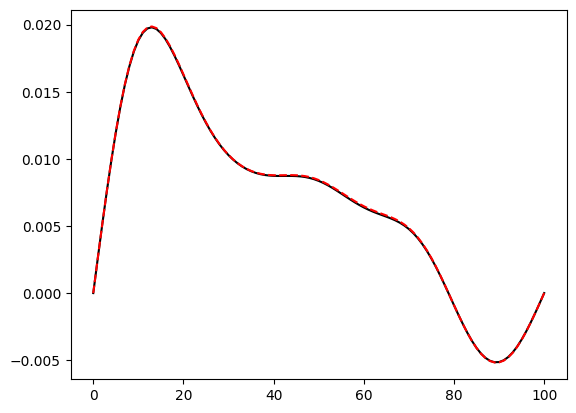

In [13]:
plt.plot(u_test[10, :], "k-")
plt.plot(u_pred[10, :], "r--")
plt.show()

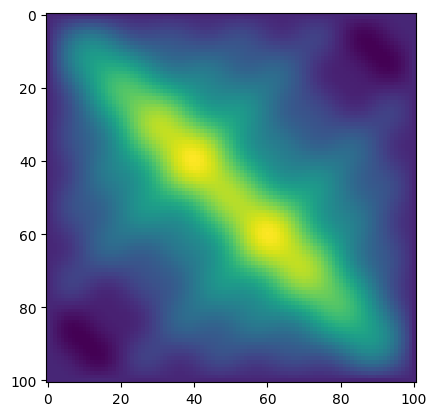

In [14]:
plt.imshow(u_pred)

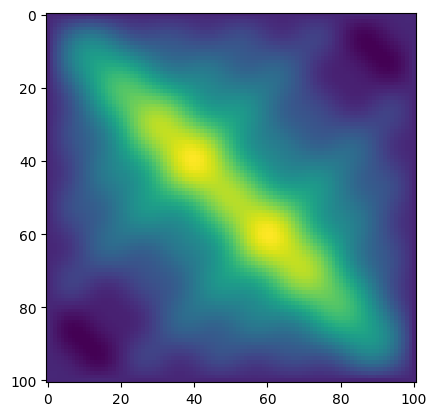

In [15]:
plt.imshow(u_test)

In [16]:
sio.savemat(
    "./outputs/gd.mat",
    {
        "x_test": x_test,
        "y_test": y_test,
        "u_exact": u_test,
        "f_exact": f_test,
        "f_pred": f_pred,
        "u_pred": u_pred,
        "x_train": x_train,
        "y_train": y_train,
        "f_train": f_train,
        "xx": xx_test, "yy": yy_test,
    }
)

In [20]:
np.mean(np.abs(f_train))

0.15468337